In [25]:
%matplotlib inline
import sys
import os
import csv
import numpy as np
import pandas as pd
sys.path.append("/Users/edwardlrichards/compAcoustics") 
import makeEnv
import matplotlib
import matplotlib.pylab as plt
matplotlib.style.use('ggplot')

from normalMode import Chinook
from wni import Corgi

In [26]:
# SwellEx enviornmental data
ctdNumber = 5
frequency = 49

In [27]:
# Water column
rho_w = 1000
atten_w = 0
z_bot = 216.5
# Read CTD data
ctdPath = "/Users/edwardlrichards/ctds"
ctdPrefix = "i96"
ctdSuffix = ".prn"
ctdName = os.path.join(ctdPath, ctdPrefix + '{0:02d}'.format(ctdNumber) + ctdSuffix)
ctd = pd.read_csv(ctdName, sep='\s+',\
                  names = ['temperature [C]', 'salinity [PSU]',\
                           'sound speed [m/sec]', 'sigma-t'])
lastValue = ctd.tail(1)
lastValue.index = [z_bot]
ctd = ctd.append(lastValue)

In [28]:
# Sediment 1
cTop = 1572.3
cBot = 1593
rho_b1 = 1760
atten_b1 = 0.2  # dB/kmHz
zBot = 23.5
z_b1 = np.r_[0:zBot:5j]
c_b1 = (z_b1 * (cBot - cTop) / np.max(z_b1)) + cTop

In [29]:
# Sediment 2
cTop = 1881
cBot = 3245
rho_b2 = 2060
atten_b2 = 0.06
zBot = 800
z_b2 = np.r_[0:zBot:5j]
c_b2 = (z_b1 * (cBot - cTop) / np.max(z_b2)) + cTop

In [30]:
# Basement
rho_b = 2.66
atten_b = 0.02
c_b = 5200

In [31]:
# sortof a random atten conversion
c = 1500
f = 100
l = c / f
conversion = c / 1000
atten_w *= conversion
atten_b1 *= conversion
atten_b2 *= conversion
atten_b *= conversion

In [32]:
# Save layers
ssp = ctd['sound speed [m/sec]']
layer_w = (np.array(ssp.index), ssp.values, rho_w, atten_w)
layer_b1 = (np.max(layer_w[0]) + z_b1, c_b1, rho_b1, atten_b1)
layer_b2 = (np.max(layer_b1[0]) + z_b2, c_b2, rho_b2, atten_b2)
layer_b = (np.max(layer_b2[0]), c_b, rho_b, atten_b)

layers = [layer_w, layer_b1, layer_b2, layer_b]
enviornment = makeEnv.acousticEnv()
enviornment.addProfile(layers, 0)

In [33]:
zRange = np.r_[0:200:100j]
rRange = np.r_[10:10000:200j]

In [34]:
# Deep source hypothesis
zSource_deep = 50

In [35]:
wni_model = Corgi(enviornment, zSource_deep, frequency, zRange,\
                   np.max(rRange))
wni_model.integrateSpectrum()
p_wni_deep = wni_model.getPressure()
v_wni_deep = 1j * 2 * np.pi * frequency * wni_model.getDisplacement()

In [36]:
# Transmission loss plot
TL_wni = 20 * np.log10(np.abs(np.array(p_wni_deep) + np.spacing(1)))
r_wni = p_wni_deep.index
Z, R = np.meshgrid(zRange, r_wni)
plt.pcolormesh(R.T, Z.T, np.array(TL_wni).T)

_ = plt.clim(-80, -50)
_ = plt.xlim(0, 10000)
_ = plt.ylim(200,0)
_ = plt.colorbar()

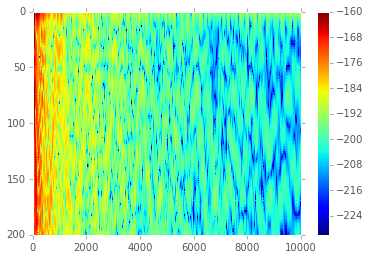

In [37]:
# Transmission loss plot
TL_v_wni = 20 * np.log10(np.abs(np.array(v_wni_deep) + np.spacing(1)))
r_wni = v_wni_deep.index
Z, R = np.meshgrid(zRange, r_wni)
plt.pcolormesh(R.T, Z.T, np.array(TL_v_wni).T)

_ = plt.clim(-230, -160)
_ = plt.xlim(0, 10000)
_ = plt.ylim(200,0)
_ = plt.colorbar()

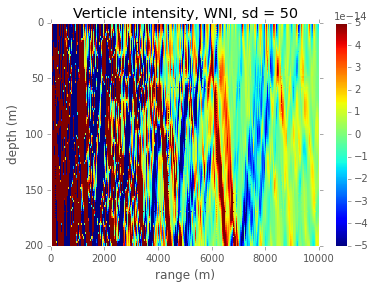

In [60]:
# Transmission loss plot
TL_v_wni = 0.5 * np.real(p_wni_deep * np.array(v_wni_deep).conj())
r_wni = v_wni_shallow.index
Z, R = np.meshgrid(zRange, r_wni)
plt.pcolormesh(R.T, Z.T, np.array(TL_v_wni).T)

_ = plt.clim(-5e-14, 5e-14)
_ = plt.xlim(0, 10000)
_ = plt.ylim(200,0)
_ = plt.colorbar()
_ = plt.ylabel('depth (m)')
_ = plt.xlabel('range (m)')
_ = plt.title('Verticle intensity, WNI, sd = %d' %zSource_deep)
plt.savefig('figures/measured_Iz')

In [38]:
# Shallow source hypothesis
zSource_shallow = 3

In [39]:
wni_model = Corgi(enviornment, zSource_shallow, frequency, zRange,\
                   np.max(rRange))
wni_model.integrateSpectrum()
p_wni_shallow = wni_model.getPressure()
v_wni_shallow = 1j * 2 * np.pi * frequency * wni_model.getDisplacement()

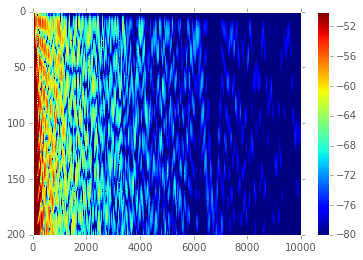

In [40]:
# Transmission loss plot
TL_wni = 20 * np.log10(np.abs(np.array(p_wni_shallow) + np.spacing(1)))
r_wni = p_wni_shallow.index
Z, R = np.meshgrid(zRange, r_wni)
plt.pcolormesh(R.T, Z.T, np.array(TL_wni).T)

_ = plt.clim(-80, -50)
_ = plt.xlim(0, 10000)
_ = plt.ylim(200,0)
_ = plt.colorbar()

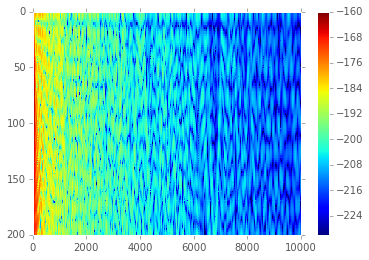

In [41]:
# Transmission loss plot
TL_v_wni = 20 * np.log10(np.abs(np.array(v_wni_shallow) + np.spacing(1)))
r_wni = v_wni_shallow.index
Z, R = np.meshgrid(zRange, r_wni)
plt.pcolormesh(R.T, Z.T, np.array(TL_v_wni).T)

_ = plt.clim(-230, -160)
_ = plt.xlim(0, 10000)
_ = plt.ylim(200,0)
_ = plt.colorbar()

In [19]:
# Vertical intensity comparison
zReciever = 212.25
# H1
wni_model = Corgi(enviornment, zSource_deep, frequency, zReciever,\
                   np.max(rRange))
wni_model.integrateSpectrum()
p_wni_deep = wni_model.getPressure()
v_wni_deep = 1j * 2 * np.pi * frequency * wni_model.getDisplacement()
H_50 = p_wni_deep * np.array(v_wni_deep).conj()
# H2
wni_model = Corgi(enviornment, zSource_shallow, frequency, zReciever,\
                   np.max(rRange))
wni_model.integrateSpectrum()
p_wni_shallow = wni_model.getPressure()
v_wni_shallow = 1j * 2 * np.pi * frequency * wni_model.getDisplacement()
H_3 = p_wni_shallow * np.array(v_wni_shallow).conj()

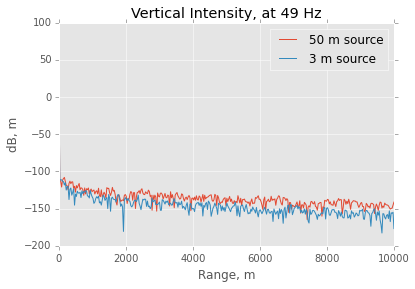

In [20]:
_ = plt.plot(H_50.index, 10 * np.log10(0.5 * np.abs(np.real(H_50))),\
                                   label = '50 m source')
_ = plt.plot(H_3.index, 10 * np.log10(0.5 * np.abs(np.real(H_3))),\
                                  label = '3 m source')
# plt.ylim(-320, -200)
_ = plt.xlim(0, 10000)
_ = plt.title('Vertical Intensity, at ' + str(frequency) + ' Hz')
_ = plt.xlabel('Range, m')
_ = plt.ylabel('dB, m')
_ = plt.legend()

In [21]:
# Vertical intensity comparison
zReciever = 212.25
frequency2 = 64
# H1
wni_model = Corgi(enviornment, zSource_deep, frequency2, zReciever,\
                   np.max(rRange))
wni_model.integrateSpectrum()
p_wni_deep = wni_model.getPressure()
v_wni_deep = 1j * 2 * np.pi * frequency * wni_model.getDisplacement()
H_50 = p_wni_deep * np.array(v_wni_deep).conj()
# H2
wni_model = Corgi(enviornment, zSource_shallow, frequency2, zReciever,\
                   np.max(rRange))
wni_model.integrateSpectrum()
p_wni_shallow = wni_model.getPressure()
v_wni_shallow = 1j * 2 * np.pi * frequency * wni_model.getDisplacement()
H_3 = p_wni_shallow * np.array(v_wni_shallow).conj()

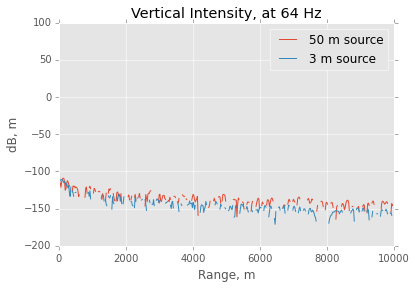

In [22]:
plt.plot(H_50.index, 10 * np.log10(0.5 * np.real(H_50)), label = '50 m source')
plt.plot(H_3.index, 10 * np.log10(0.5 * np.real(H_3)), label = '3 m source')
# plt.ylim(-320, -200)
_ = plt.xlim(0, 10000)
_ = plt.title('Vertical Intensity, at ' + str(frequency2) + ' Hz')
_ = plt.xlabel('Range, m')
_ = plt.ylabel('dB, m')
_ = plt.legend()